## Loading model checkpoints

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# reload 

from pathlib import Path
import json
from models.model_configs import instantiate_model
import torch
from training.eval_loop import CFGScaledModel
from flow_matching.path import MixtureDiscreteProbPath
from flow_matching.path.scheduler import PolynomialConvexScheduler
from flow_matching.solver.ode_solver import ODESolver
from flow_matching.solver.discrete_solver import MixtureDiscreteEulerSolver
from matplotlib import pyplot as plt

import argparse
import torch.serialization

In [3]:
import torchvision.datasets as datasets
from datasets import LIDCDataset, ISIC2016Dataset, ISIC2018Dataset, MSMRIDataset
from training.data_transform import get_train_transform, TransformDataset

def get_dataset(args_dict, sample_resolution):
    if args_dict['dataset'] == "mnist":
        dataset = datasets.MNIST(root=args_dict['data_path'],
                            train=False,
                            download=True,
                            transform=get_train_transform())
    elif args_dict['dataset'] == "lidc":
        dataset = LIDCDataset(data_dir=args_dict['data_path'],
                            train_val_test_dir='Val',
                            mask_type="multi")
        dataset = TransformDataset(dataset, 
                                    height=sample_resolution, 
                                    width=sample_resolution)
    elif "isic" in args_dict['dataset']:
        if args_dict['dataset'] == "isic2016":
            dataset = ISIC2016Dataset(data_dir=args_dict['data_path'],
                                        train_val_test_dir='Test')
        elif args_dict['dataset'] == "isic2018":
            dataset = ISIC2018Dataset(data_dir=args_dict['data_path'],
                                        train_val_test_dir='Test')
        args_dict['dataset'] = "isic"
        dataset = TransformDataset(dataset, 
                                    height=sample_resolution, 
                                    width=sample_resolution)
    elif args_dict['dataset'] == "msmri":
        dataset = MSMRIDataset(data_dir=args_dict['data_path'],
                            train_val_test_dir='Val',
                            mask_type="multi")
        dataset = TransformDataset(dataset, 
                                    height=sample_resolution, 
                                    width=sample_resolution)
    return dataset

In [4]:
# Substitute your pretrained checkpoint path
checkpoint_path = Path("./output_dir/lidc_condition_random/checkpoint-399.pth")

args_filepath = checkpoint_path.parent / 'args.json'
with open(args_filepath, 'r') as f:
    args_dict = json.load(f)

# Set the sampling resolution corresponding to the model
sample_resolution = args_dict['img_size']
print("sample_resolution:", sample_resolution)

dataset = get_dataset(args_dict, sample_resolution)
model = instantiate_model(architechture=args_dict['dataset'] + ("_condition" if args_dict["condition"] else ""), 
                          is_discrete='discrete_flow_matching' in args_dict and args_dict['discrete_flow_matching'],
                          use_ema=args_dict['use_ema'])

torch.serialization.add_safe_globals([argparse.Namespace]) # for pytorch 2.6
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(checkpoint["model"])

device = 'cuda'
model.to(device=device)
cfg_weighted_model = CFGScaledModel(model)

sample_resolution: 128


## Sampling

In [5]:

from functools import partial

solver = ODESolver(velocity_model=cfg_weighted_model)

# Create partial functions with common arguments pre-filled
sample_partial = partial(
    solver.sample,
    time_grid=torch.tensor([0.0, 1.0], device=device),
    method=args_dict['ode_method'],
    atol=args_dict['ode_options']['atol'] if 'atol' in args_dict['ode_options'] else None,
    rtol=args_dict['ode_options']['rtol'] if 'rtol' in args_dict['ode_options'] else None,
    step_size=(args_dict['ode_options']['step_size'] if 'step_size' in args_dict['ode_options'] else None),
)

compute_likelihood_partial = partial(
    solver.compute_likelihood,
    time_grid=torch.tensor([1.0, 0], device=device),
    log_p0=lambda x: torch.zeros_like(x),  # ignore for now
    method=args_dict['ode_method'],
    atol=args_dict['ode_options']['atol'] if 'atol' in args_dict['ode_options'] else None,
    rtol=args_dict['ode_options']['rtol'] if 'rtol' in args_dict['ode_options'] else None,
    step_size=(args_dict['ode_options']['step_size'] if 'step_size' in args_dict['ode_options'] else None),
    enable_grad=True
)

print("Discrete:", args_dict['discrete_flow_matching'])
print("Condition:", args_dict['condition'])

Discrete: False
Condition: True


In [6]:
def decode(x):
    x = torch.clamp(x * 0.5 + 0.5, min=0.0, max=1.0)
    # x = torch.floor(x * 255) / 255.0
    x = (x > 0.7).to(torch.int64)
    return x

def encode(x):
    x = torch.clamp(x * 255, min=0.0, max=255.0)
    x = (x - 127.5) / 127.5
    return x

def visualize(images, n_images = 8, name=None, figsize=(20, 6)):
    _, axs = plt.subplots(len(images), n_images, figsize=figsize)
    for i in range(len(images)):
        for j in range(n_images):
            axs[i, j].imshow(images[i][j].permute(1, 2, 0).cpu().numpy(), cmap='gray')
            axs[i, j].axis('off')
    if name:
        plt.savefig(f"{name}.jpg", bbox_inches='tight')
    plt.show()

## Test

In [51]:
import torch
import random
import numpy as np
seed = 50
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
from torch.utils.data import DataLoader

batch_size = 4
print("batch_size:", batch_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
masks, images = next(iter(dataloader))
masks = [mask.to(device) for mask in masks]
images = images.to(device)
mask_e = torch.mean(torch.stack(masks, dim=0), dim=0)

batch_size: 4


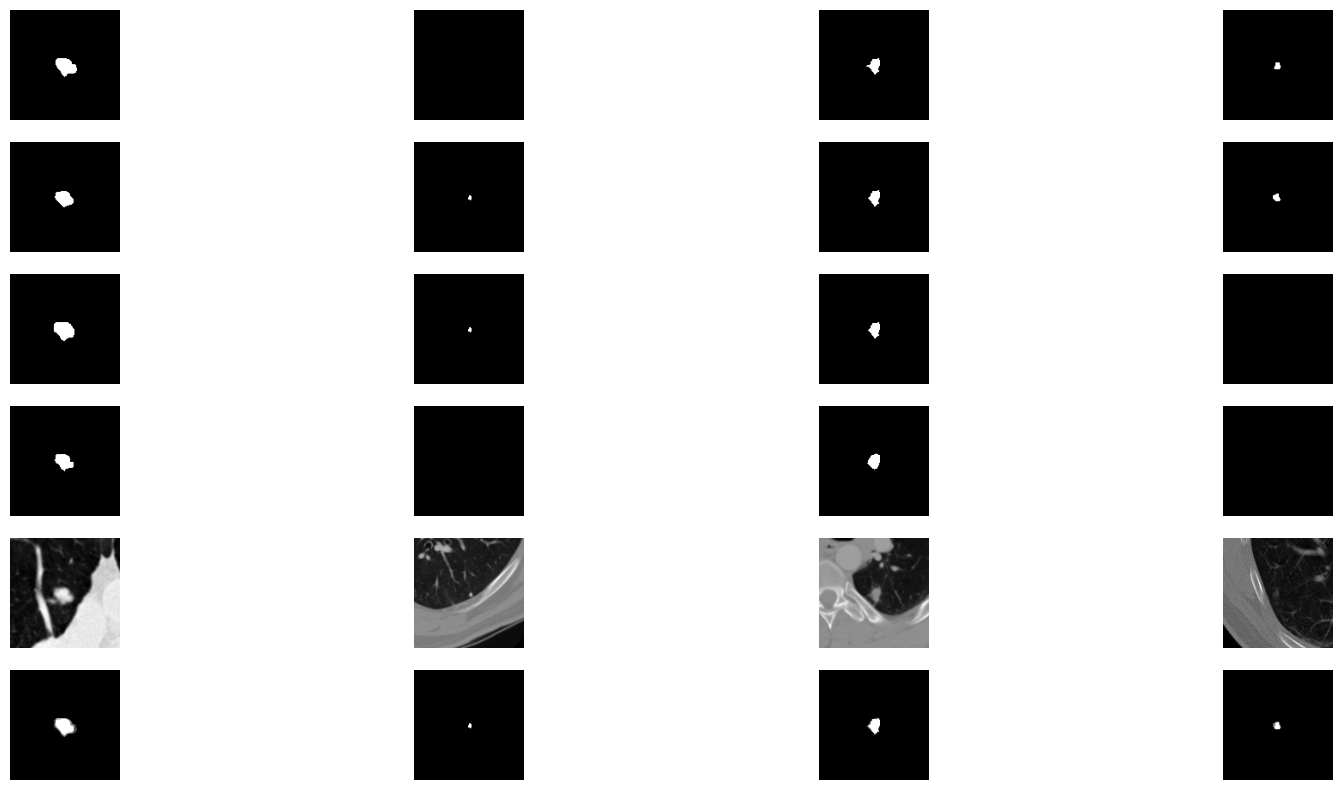

In [52]:
imgs = masks + [images, mask_e] 
visualize(imgs, n_images=4, figsize=(20, 10))

In [53]:
x_0s = [compute_likelihood_partial(mask, label=None, cfg_scale=-1) for mask in masks]

/work/dat-nt/2025/flow-matching/training/eval_loop.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/work/dat-nt/anaconda3/envs/flow_matching/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [54]:
uncond_samples = [sample_partial(x_0, label=images, cfg_scale=-1) for x_0 in x_0s]

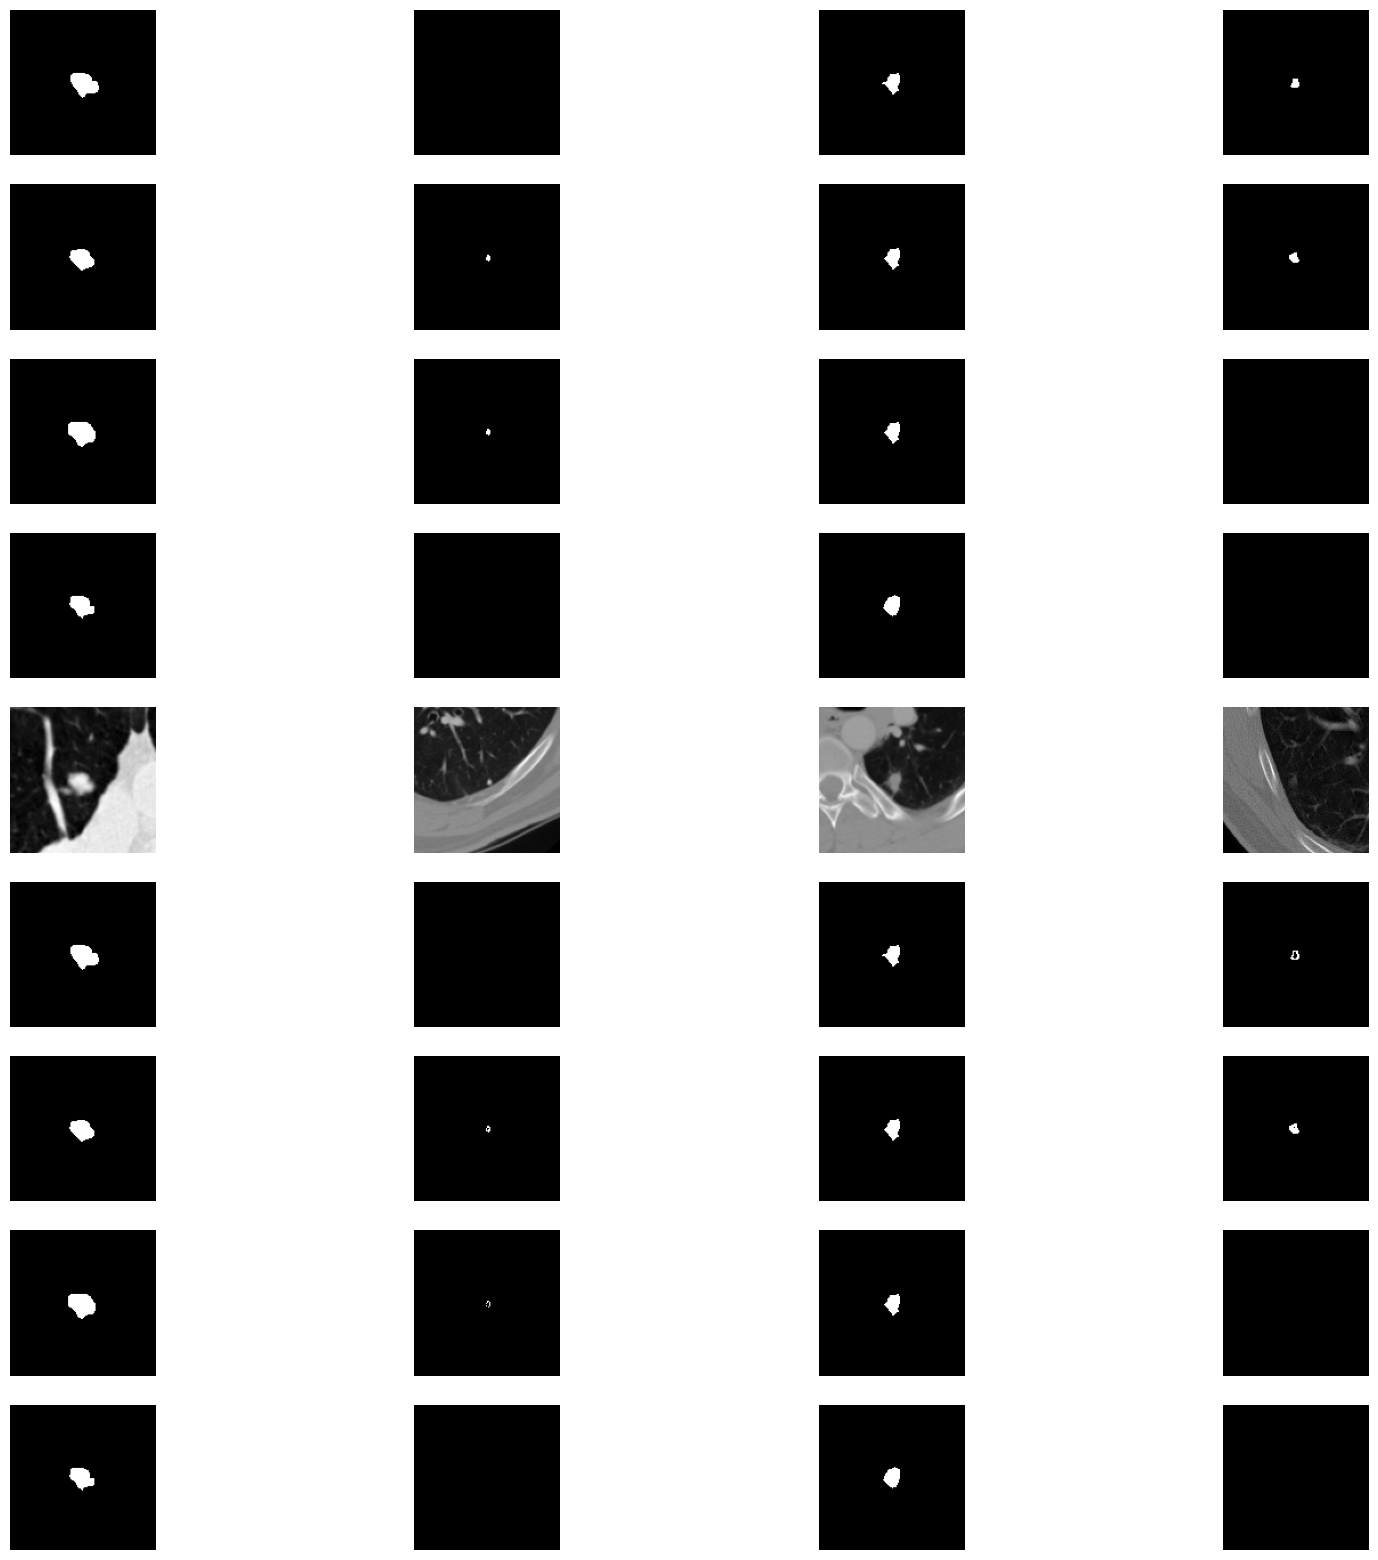

In [55]:
imgs = masks + [images] + [decode(sample) for sample in uncond_samples]
visualize(imgs, n_images=4, figsize=(20, 20))

In [56]:
cond_samples = [sample_partial(x_0, label=images, cfg_scale=args_dict['cfg_scale']) for x_0 in x_0s]

/work/dat-nt/2025/flow-matching/training/eval_loop.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


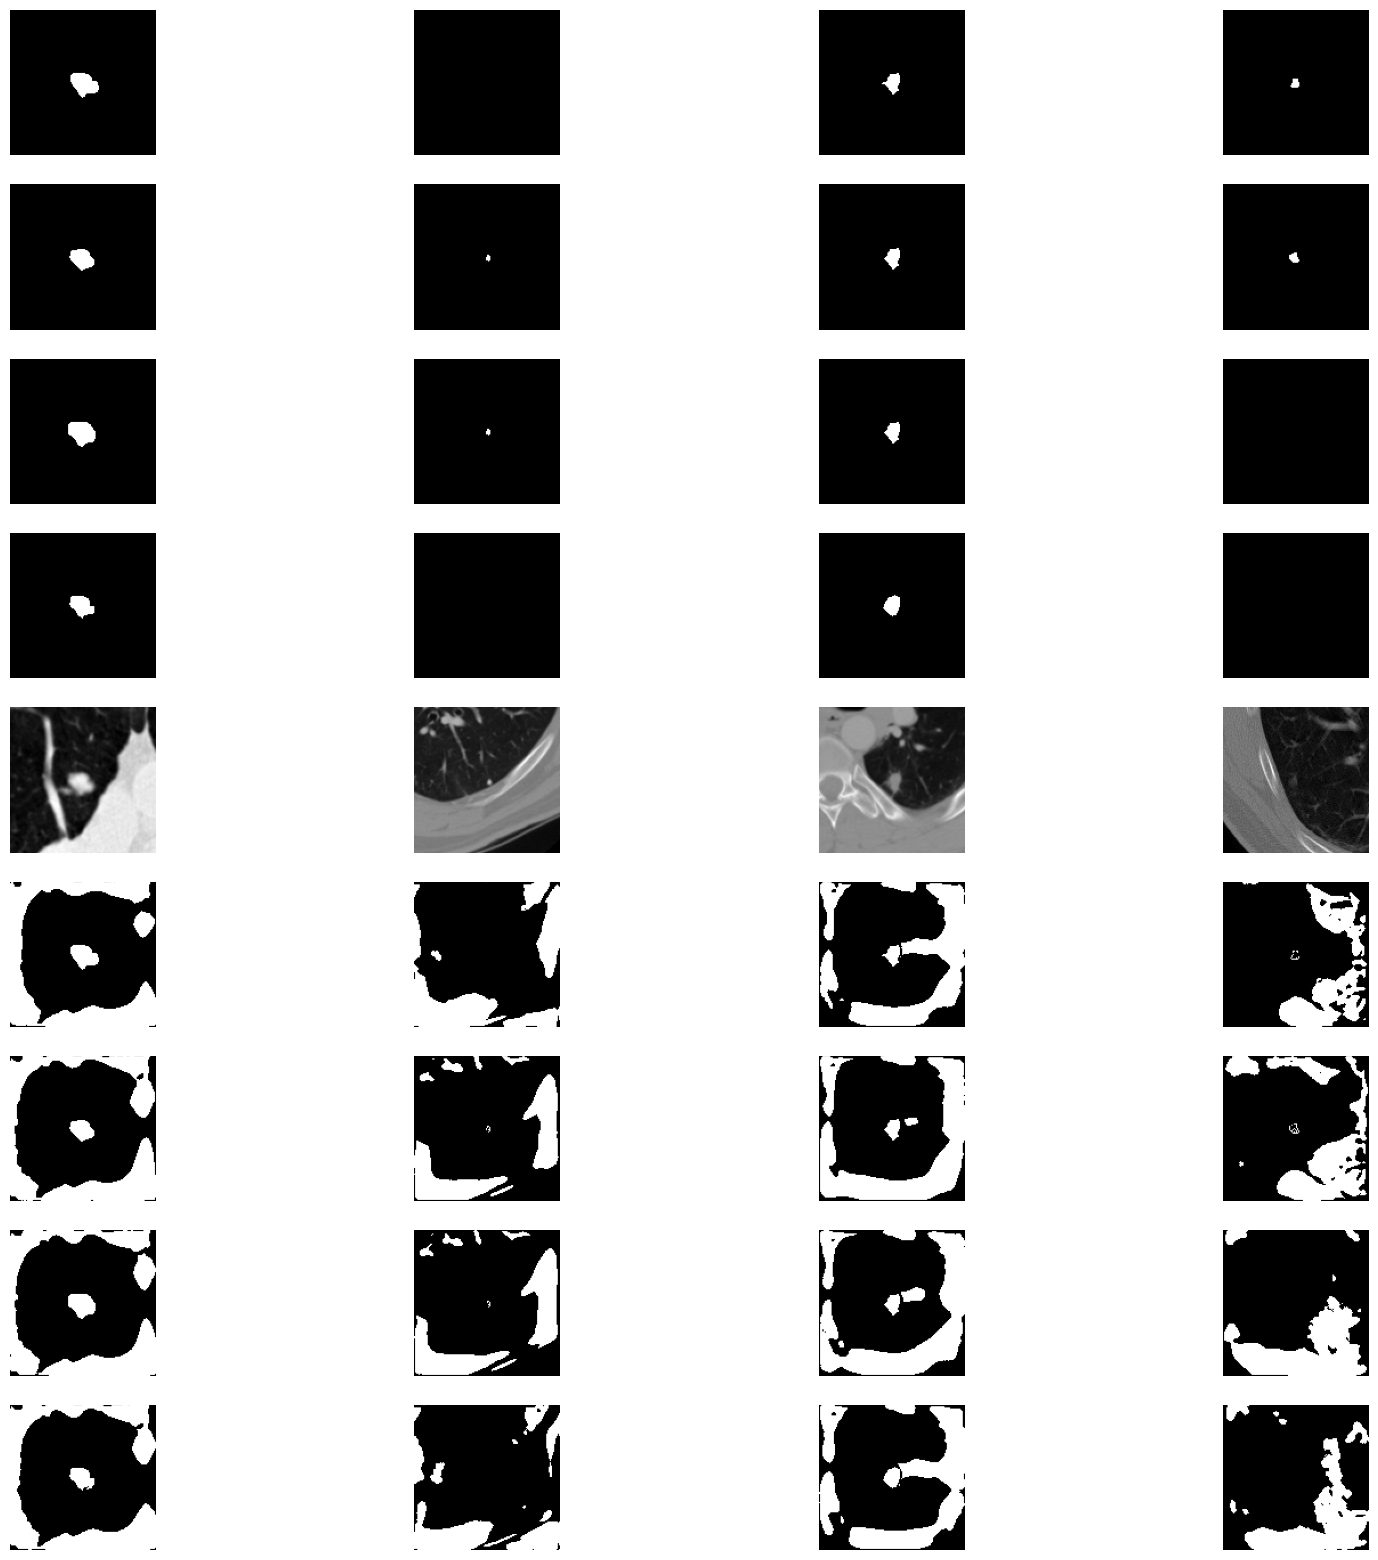

In [57]:
imgs = masks + [images] + [decode(sample) for sample in cond_samples]
visualize(imgs, n_images=4, figsize=(20, 20))

In [58]:
x_0_0, x_0_1 = x_0s[0], x_0s[-1]

max_step = 10
alphas = [t / max_step for t in range(0, max_step + 1)]
uncond_interpolated_samples = []
for alpha in alphas:
    x_0 = x_0_0 * alpha + (1 - alpha) * x_0_1
    uncond_interpolated_samples.append(sample_partial(x_0, label=images, cfg_scale=-1))

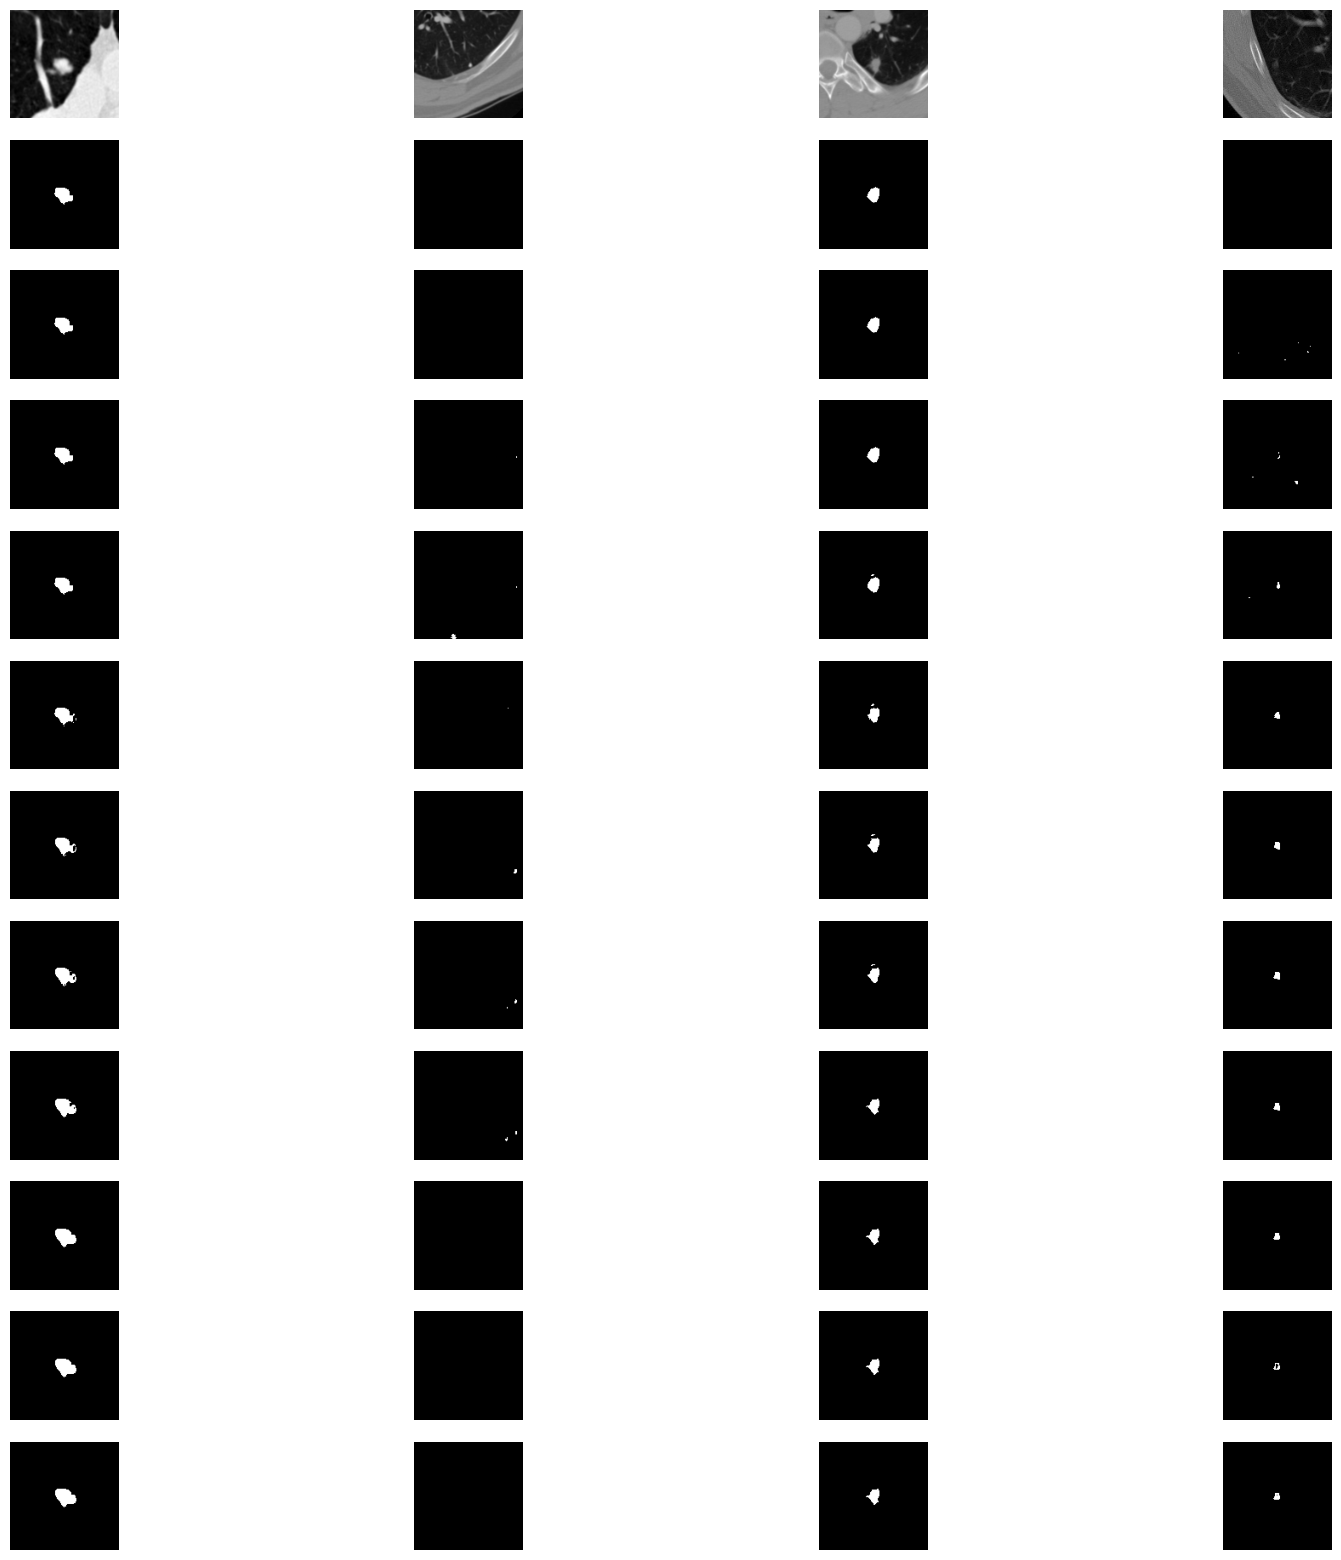

In [59]:
imgs = [images] + [decode(sample) for sample in uncond_interpolated_samples]
visualize(imgs, n_images=4, figsize=(20, 20))

In [ ]:
mask_mean = torch.mean(torch.stack(masks, dim=0), dim=0)
mask_std = torch.std(torch.stack(masks, dim=0), dim=0)

local_masks = []
for i in range(5):
    mask = mask_mean + mask_std * torch.randn_like(mask_mean)
    local_masks.append(mask)

In [66]:
mask_mean.max(), mask_mean.min(), mask_std.max(), mask_std.min()

(tensor(1., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0.5774, device='cuda:0'),
 tensor(0., device='cuda:0'))

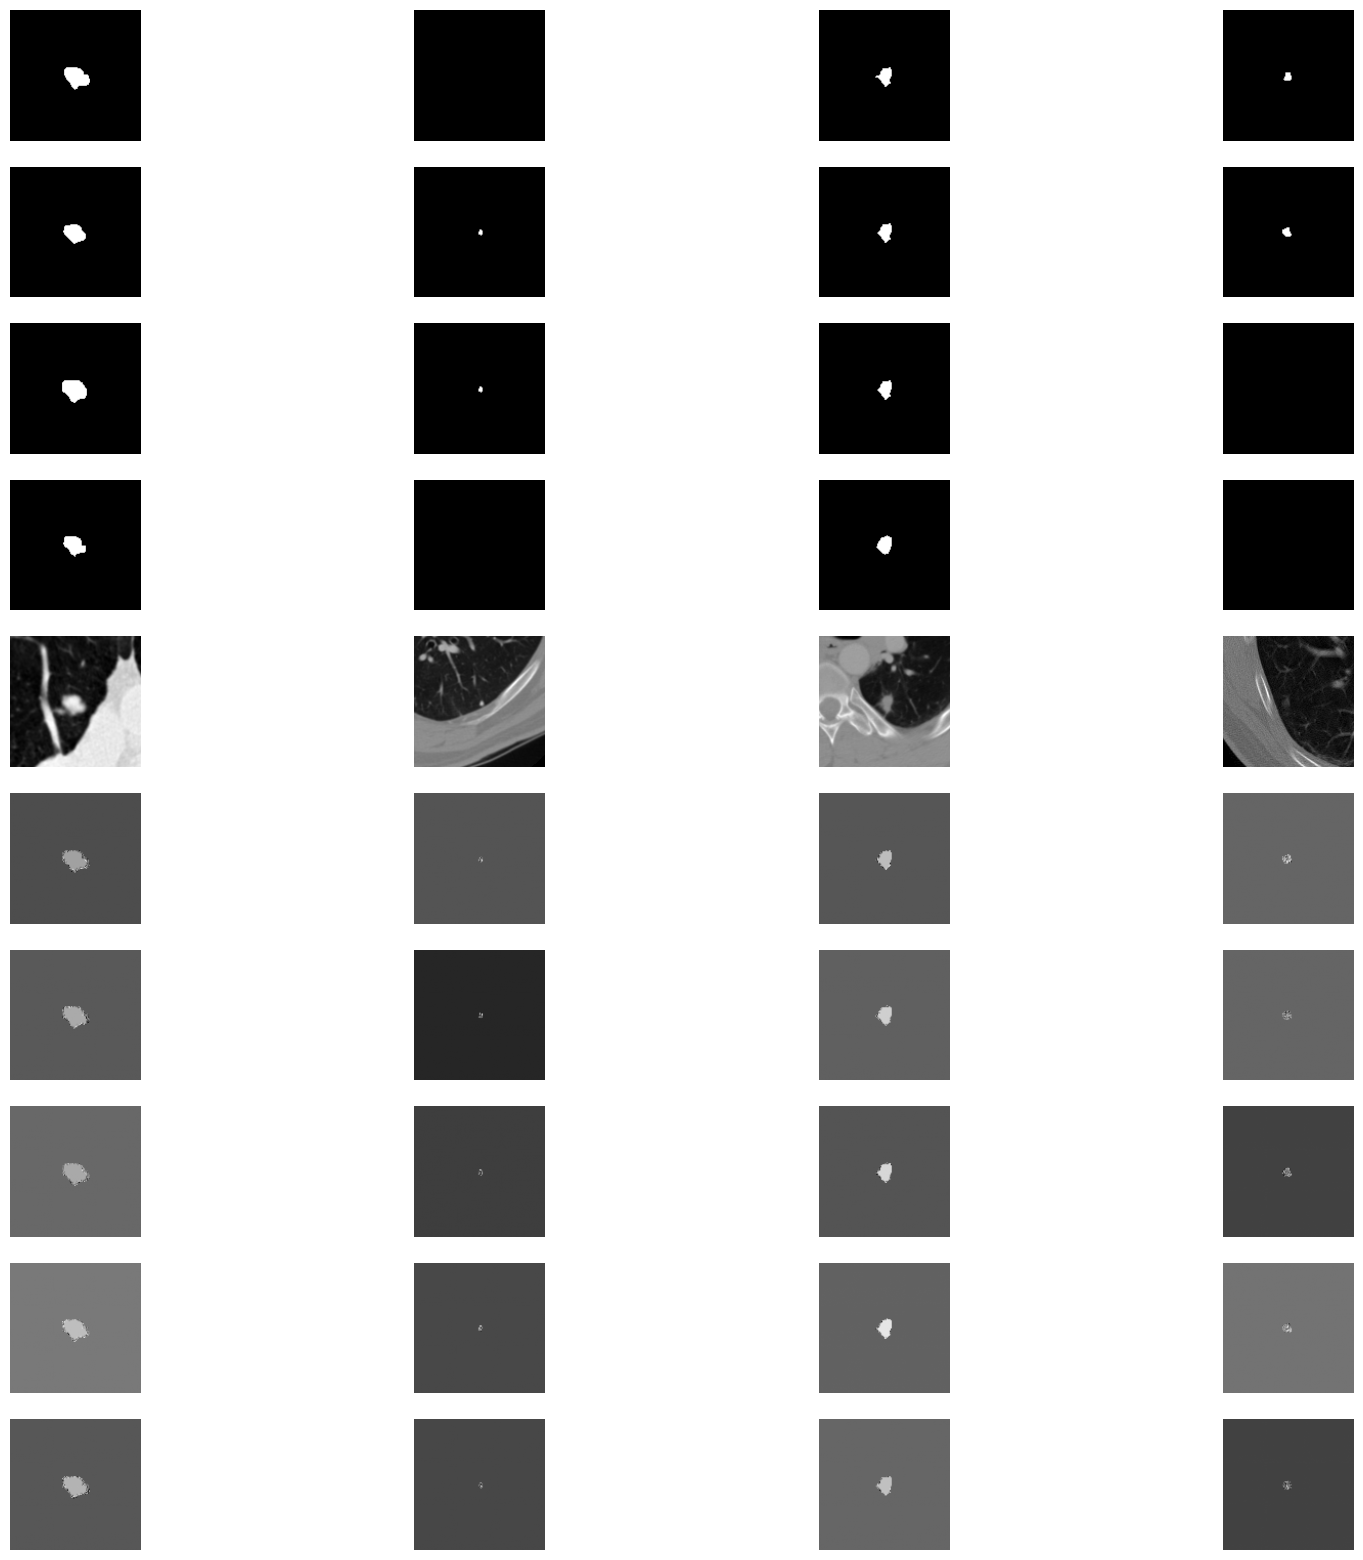

In [ ]:
imgs = masks + [images] + [decode(mask) for mask in local_masks]
visualize(imgs, n_images=4, figsize=(20, 20))

In [62]:
x_0_mean = torch.mean(torch.stack(x_0s, dim=0), dim=0)
x_0_std = torch.std(torch.stack(x_0s, dim=0), dim=0)

uncond_local_samples = []
for i in range(5):
    x_0 = mask_mean + mask_std * torch.randn_like(mask_mean)
    uncond_local_samples.append(sample_partial(x_0, label=images, cfg_scale=-1))

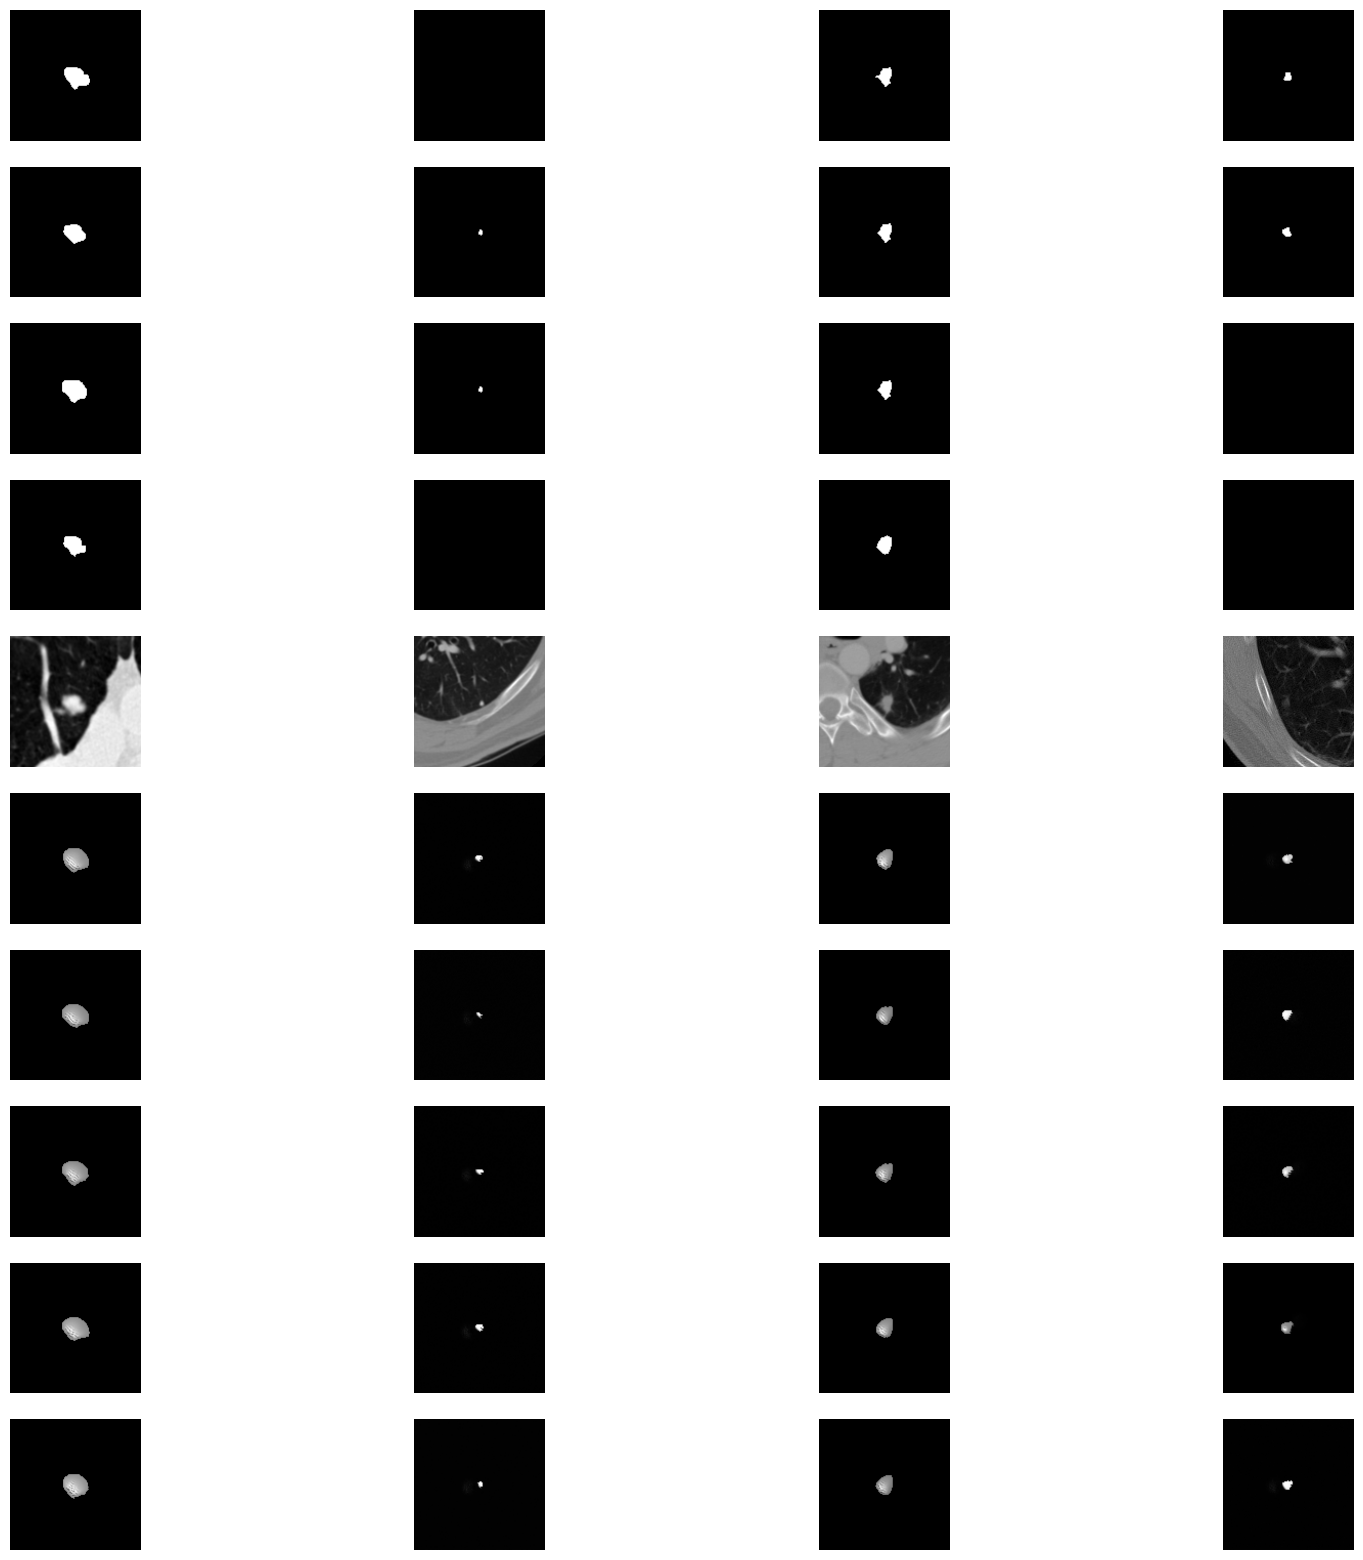

In [ ]:
imgs = masks + [images] + [decode(sample) for sample in uncond_local_samples]
visualize(imgs, n_images=4, figsize=(20, 20))